# Mašinsko učenje za detekciju emocija

In [1]:
import cv2 as cv
import numpy as np
from os import walk
import io
import pandas as pd
import seaborn as sn

from pathlib import Path

from timeit import default_timer as timer

import matplotlib
import matplotlib.pyplot as plt

from sklearn import tree, neighbors, naive_bayes, svm, ensemble

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, log_loss, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

C:\Users\Nevena\AppData\Local\Temp\ipykernel_27792\1535163856.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Funkcije za učitavanje podataka

In [2]:
def walk_through_dir(dir_path: Path) -> dict:
    """Prints dir_path content"""
    counts = dict()
    classes = dict()
    i=-1
    for dirpath, dirnames, filenames in walk(dir_path):
        i = i+1
        #print(f"There are {len(dirnames)} directiories and {len(filenames)} images in '{dirpath}' folder ")
        if (i>0):
            c = dirpath.split('\\')
            counts[c[-1]] = len(filenames)
            classes[c[-1]] = i
    return (counts, classes)

images_path = Path("upscaled_images")
ctrain, classes = walk_through_dir(images_path / 'train')


def make_datasets(counts, dataset_type, path, upscale = ""):
    x = []
    y = []

    for label, count in counts.items():
        for i in range(0, count):
            suffix = f"{dataset_type}/{label}/im{i}.png" if upscale == "" else f"{dataset_type}/{label}/im{i}_{upscale}.png"
            #print(path / suffix)
            img = cv.imread(path / suffix)
            img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
            x.append(img)
            y.append(label)

            # if i==0: 
            #     cv.imshow(mat=img, winname="asdfghjklasdfghjkl")
            #     cv.waitKey(0)
            #     cv.destroyAllWindows()
    x = np.array(x).astype(np.float32)
    x = x.reshape(x.shape[0], (x.shape[1]*x.shape[2])) / 255
    return (x, y)

def replace_label(y, classes):
    y_new = [classes[label] for label in y]
    return np.array(y_new)

In [3]:
def make_datasets_balanced(counts, dataset_type, path, upscale = ""):
    x = []
    y = []

    c_min = min(list(counts.values()))

    for label, count in counts.items():
        for i in range(0, c_min):
            suffix = f"{dataset_type}/{label}/im{i}.png" if upscale == "" else f"{dataset_type}/{label}/im{i}_{upscale}.png"
            #print(path / suffix)
            img = cv.imread(path / suffix)
            img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
            x.append(img)
            y.append(label)

            # if i==0: 
            #     cv.imshow(mat=img, winname="asdfghjklasdfghjkl")
            #     cv.waitKey(0)
            #     cv.destroyAllWindows()
    x = np.array(x).astype(np.float32)
    x = x.reshape(x.shape[0], (x.shape[1]*x.shape[2])) / 255
    return (x, y)

## Funkcije za evaluaciju

In [4]:
def makeClassificationReport(pred, modelName, target_test):
    cm = confusion_matrix(target_test, pred, normalize="pred")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.grid(visible=False)
    plt.title(f"Confusion Matrix - {modelName}")
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(visible=None)
    plt.savefig(f"graphs/confusionMatrix{modelName}.jpg")
    #plt.show()

    report = classification_report(target_test,pred, digits=5)
    with io.open(f'evaluation/classification_report{modelName}.txt','w',encoding='utf-8') as f: f.write(report)

def plotROC(model,model_name,data_test,target_test):

    target_probabilities = model.predict_proba(data_test)[:,1]

    false_positive_rate, true_positive_rate, threshold = roc_curve(target_test,target_probabilities)

    plt.title(f"Receiver Operating Characteristic - {model_name}")
    plt.plot(false_positive_rate, true_positive_rate, marker='.')
    plt.plot([0, 1], ls="--")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.savefig(f"graphs/roc{model_name}.jpg")
    plt.show()

    lr_auc = roc_auc_score(target_test, target_probabilities)
    print('ROC AUC=%.10f' % (lr_auc))

def calculateLogLoss(model, modelName, data_test,target_test):
    target_probabilities = model.predict_proba(data_test)[:,1]
    y.append(log_loss(target_test, target_probabilities))

## Učitavanje podataka

In [5]:
datasets = dict()

def load_data(path, dataset_name, make_dataset_function, upscale=""):
    train_path = path / "train"
    test_path = path / "test"

    ctrain, classes = walk_through_dir(train_path)
    ctest, _ = walk_through_dir(test_path)

    x_train, y_tr = make_dataset_function(ctrain, "train", path, upscale)
    x_test, y_te = make_dataset_function(ctest, "test", path, upscale)

    y_train = replace_label(y_tr, classes)
    y_test  = replace_label(y_te, classes)

    datasets[dataset_name] = { "train": (x_train, y_train), "test": (x_test, y_test) }

### Čist dataset

In [6]:
data_path = Path("Kaggle/CV/Emotions_detection")
images_path = data_path / "emotions_dataset"

load_data(images_path, 'original', make_datasets)

In [7]:
datasets['original']['train'][0][0]

array([0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
       0.32156864], dtype=float32)

### Upscaled slike

In [8]:
images_path = Path("upscaled_images")
load_data(images_path, 'upscaled', make_datasets, '4')

### Balansiran dataset

In [9]:
data_path = Path("Kaggle/CV/Emotions_detection")
images_path = data_path / "emotions_dataset"
load_data(images_path, 'original_balanced', make_datasets_balanced)

images_path = Path("upscaled_images")
load_data(images_path, 'upscaled_balanced', make_datasets_balanced, '4')

## Klasifikatori

In [10]:
base_classifiers = [
    neighbors.KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree', n_jobs=6),
    #svm.SVC(kernel='rbf', class_weight='balanced', break_ties=True, max_iter=5000),
    naive_bayes.ComplementNB(),
    tree.DecisionTreeClassifier()
]
names = [
    "KNN",
    #"SVC",
    "NaiveBayes",
    "DecisionTree"]
estimators = list(zip(names, base_classifiers))

classifiers = {
    "KNN": base_classifiers[0],
    #"SVC": base_classifiers[1],
    "NaiveBayes": base_classifiers[1],
    "DecisionTree": base_classifiers[2],
    "RandomForest": ensemble.RandomForestClassifier(criterion='log_loss', n_jobs=10),
    "AdaBoost": ensemble.AdaBoostClassifier(),
    "BaggingClassifier": ensemble.BaggingClassifier(n_jobs=10, random_state=32),
    "VotingClassifier": ensemble.VotingClassifier(estimators=estimators),
    "StackingClassifier": ensemble.StackingClassifier(estimators=estimators, n_jobs=10, cv=5),
    "CatBoost": CatBoostClassifier(iterations=5000,
                           task_type="GPU",
                           devices='0'),
    "XGBoost": XGBClassifier(n_estimators=20, max_depth=50, learning_rate=0.1, objective='multi:softmax', device='cuda',num_class=7)
}

models = []
preds = []

In [11]:
def models_fit(classifiers, x_train, y_train, x_test, y_test, dataset_name):
    models = dict()
    preds = dict()
    for c in classifiers:
        path = Path(f'evaluation/classification_report_{dataset_name}__{c}.txt')
        if path.is_file():
            print(f"Skipping training {c} on {dataset_name} dataset - model already trained.")
            continue

        if ('upscaled' == dataset_name and c in ['BaggingClassifier', 'VotingClassifier', 'StackingClassifier', 'CatBoost']) or ('upscaled_balanced' == dataset_name and c == 'CatBoost'):
            # Skip BaggingClassifier on large amount of data (Memory error)
            print(f"Skipping training {c} on {dataset_name} dataset - Memory Error")
            continue

        if c == "XGBoost":
            y_train = y_train - 1
            y_test = y_test -1

        print(f"    Fitting model: {c}")
        try:
            start_time = timer()
            models[c] = classifiers[c].fit(x_train, y_train)
            end_time = timer()
            print(f"    Total learning time: {(end_time - start_time):.3f}")
        except Exception as e:
            print(f"Skipping training {c} on {dataset_name} dataset - an exception occured:\n{e}")
            continue

        print(f"        Making predictions...")
        start_time = timer()
        preds[c] = models[c].predict(x_test)
        end_time = timer()
        print(f"        Total prediction time: {(end_time - start_time):.3f}")
        print(f"        Evaluating...")
        makeClassificationReport(preds[c], f"_{dataset_name}__{c}", y_test)
        print(f"        Evaluation saved on disk.")
        print(f"        Fitting {c} completed.")

    return (models, preds)


In [12]:
def fit_by_dataset(classifiers, datasets, exclude_datasets = []):
    print("Start training...")
    for name, data in datasets.items():
        if name in exclude_datasets:
            continue
        print(f"Fitting on dataset: {name}")
        x_train = data['train'][0]
        y_train = data['train'][1]
        x_test = data['test'][0]
        y_test = data['test'][1]
        models_fit(classifiers, x_train, y_train, x_test, y_test, name)


## Fitting

In [13]:
fit_by_dataset(classifiers, datasets)

Start training...
Fitting on dataset: original
Skipping training KNN on original dataset - model already trained.
Skipping training NaiveBayes on original dataset - model already trained.
Skipping training DecisionTree on original dataset - model already trained.
Skipping training RandomForest on original dataset - model already trained.
Skipping training AdaBoost on original dataset - model already trained.
Skipping training BaggingClassifier on original dataset - model already trained.
Skipping training VotingClassifier on original dataset - model already trained.
Skipping training StackingClassifier on original dataset - model already trained.
Skipping training CatBoost on original dataset - model already trained.
Skipping training XGBoost on original dataset - model already trained.
Fitting on dataset: upscaled
Skipping training KNN on upscaled dataset - model already trained.
Skipping training NaiveBayes on upscaled dataset - model already trained.
Skipping training DecisionTree o

## RUN

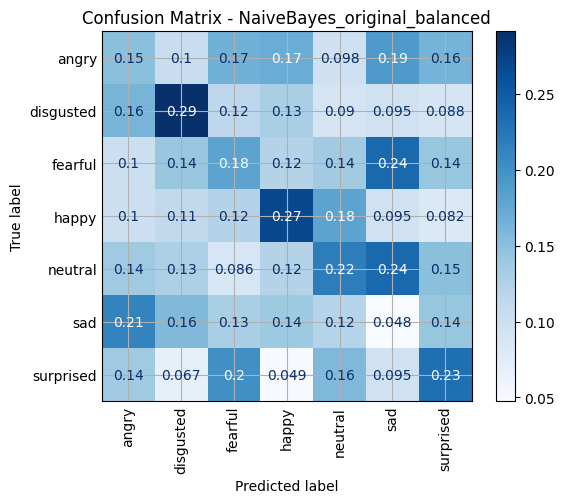

In [20]:
dataset = 'original_balanced'

x = datasets[dataset]['train'][0]
y = datasets[dataset]['train'][1]

testx = datasets[dataset]['test'][0]
testy = datasets[dataset]['test'][1]

model = classifiers['NaiveBayes'].fit(x, y)
pred = model.predict(testx)

makeClassificationReport(pred, f'NaiveBayes_{dataset}', testy)

In [11]:
catboostmodel = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0')

In [40]:
xgboost = XGBClassifier(n_estimators=20, max_depth=50, learning_rate=0.1, objective='multi:softmax', num_class=7)

In [34]:
stack = ensemble.StackingClassifier(estimators=estimators, n_jobs=10, cv=5,)

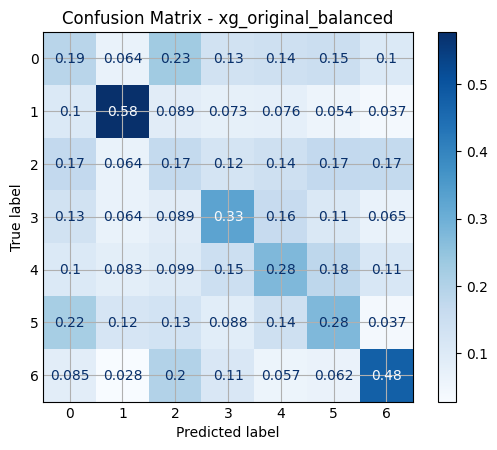

In [41]:
dataset = 'original_balanced'

x = datasets[dataset]['train'][0]
y = datasets[dataset]['train'][1] - 1

testx = datasets[dataset]['test'][0]
testy = datasets[dataset]['test'][1] - 1

model = xgboost.fit(x, y)
pred = model.predict(testx)

makeClassificationReport(pred, f'xg_{dataset}', testy)